In [1]:
using LinearAlgebra
using Distributions
using Plots
using Optim
using Cubature

In [2]:
α = 9
θ = 0.5
d = Gamma(α,θ)
f(x) = pdf(d, x)
F(x) = cdf(d, x)

F (generic function with 1 method)

In [3]:
mode_d = mode(d)

4.0

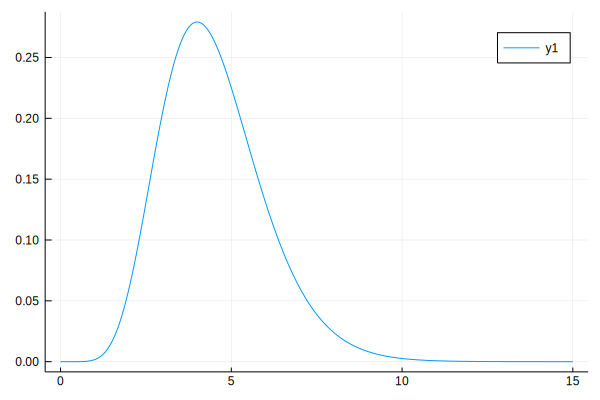

In [4]:
xgrid = 0:0.01:15
plot(xgrid, f.(xgrid))

In [5]:
wp = 0.95
bound = 80

80

In [8]:
function find_αβ(l_height, α_intvl, β_intvl)
    # find α and β within ginve intervals α_intvl and β_intvl respectively
    routine_α = optimize(x -> abs(f(x) - l_height), α_intvl[1], α_intvl[2], GoldenSection())
    α = Optim.minimizer(routine_α)
    routine_β = optimize(x -> abs(f(x) - l_height), β_intvl[1], β_intvl[2], GoldenSection())
    β = Optim.minimizer(routine_β)
    int = hquadrature(f, α, β)[1]
    return α, β, int
end

function adjust(l, α, β, int, MODE)
    # adjust if int < wp
    if MODE == "low"
        while int < wp
            l /= 2
            α, β, int = find_αβ(l, [0, α], [β, bound])
        end
    else
        while int > wp
            l = (l + f(mode_d))/2
            α, β, int = find_αβ(l, [α, mode_d], [mode_d, β])
        end
    end
    return l, α, β, int
end
        
l_height_low = 0.1
α_low, β_low, int_low = find_αβ(l_height_low, [0, mode_d], [mode_d, bound])
# println("Initial low: [$α_low, $β_low], int = $int_low")
l_height_low, α_low, β_low, int_low = adjust(l_height_low, α_low, β_low, int_low, "low")
# println("After adjustment: [$α_low, $β_low], int = $int_low")

# l_height_high = f(mode_d) - 1e-6
l_height_high = 0.03
α_high, β_high, int_high = find_αβ(l_height_high, [0, mode_d], [mode_d, bound])
# println("Initial high: [$α_high, $β_high], int = $int_high")
l_height_high, α_high, β_high, int_high = adjust(l_height_high, α_high, β_high, int_high, "high")
# println("After adjustment: [$α_high, $β_high], int = $int_high")

α_mid = 0.
β_mid = 0.
l_mid = 0.
N = 0
int = int_low
while !isapprox(int, wp) && N < 30
l_mid = (l_height_high + l_height_low)/2
α_mid, β_mid, int = find_αβ(l_mid, [α_low, α_high], [β_high, β_low])
if int > wp
    l_height_low = l_mid
    α_low = α_mid
    β_low = β_mid
else
    l_height_high = l_mid
    α_high = α_mid
    β_high = β_mid
end
N += 1
end

CI = [α_mid, β_mid, l_mid]


3-element Array{Float64,1}:
 1.8113170665466982 
 7.488659184484688  
 0.03930205361326092

In [117]:
eps = 1e-3
l_height_low = eps
routine_α = optimize(x -> abs(f(x) - l_height_low), 0, mode_d)
α_low = Optim.minimizer(routine_α)
routine_β = optimize(x -> abs(f(x) - l_height_low), mode_d, bound)
β_low = Optim.minimizer(routine_β)
int_low = hquadrature(f, α_low, β_low)[1]
# println("l = $(l_height_low), [$(α_low), $(β_low)], int = $(int_low)")

l_height_high = f(mode_d) - eps * 1e-3
routine_α = optimize(x -> abs(f(x) - l_height_high), 0, mode_d)
α_high = Optim.minimizer(routine_α)
routine_β = optimize(x -> abs(f(x) - l_height_high), mode_d, bound, GoldenSection())
β_high = Optim.minimizer(routine_β)
int_high = hquadrature(f, α_high, β_high)[1]
# println("l = $(l_height_high), [$(α_high), $(β_high)], int = $(int_high)")

l_mid = 0.
α_mid = 0.
β_mid = 0.
N = 0
int = int_low
while !isapprox(int, wp) && N < 30
l_mid = (l_height_high + l_height_low)/2
α_mid = Optim.minimizer(optimize(x -> abs(f(x) - l_mid), α_low, α_high))
β_mid = Optim.minimizer(optimize(x -> abs(f(x) - l_mid), β_high, β_low))
int = hquadrature(f, α_mid, β_mid)[1]
if int > wp
    l_height_low = l_mid
    α_low = α_mid
    β_low = β_mid
else
    l_height_high = l_mid
    α_high = α_mid
    β_high = β_mid
end
N += 1
end

CI = [α_mid, β_mid]

2-element Array{Float64,1}:
 1.8113169422418736
 7.488659540789137 